This notebook follows the tutorial here: https://machinelearningmastery.com/what-is-bayesian-optimization/

It goes through the algorithm for Bayesian optimization, but the Gaussian process regression, which to me is the most mysterious part, is done with an imported class from scikit-learn.

In [3]:
import os,sys
from numpy import *
from scipy.stats import norm
import matplotlib.pyplot as plt
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor

# How to Perform Bayesian Optimization 

## Test Problem

In [4]:
def objective(x, noise=0.1):
    """
    returns the ground truth function with noise added
    """
    noise = random.normal(loc=0, scale=noise)
    return x**2 * sin(5*pi*x)**6.0 + noise

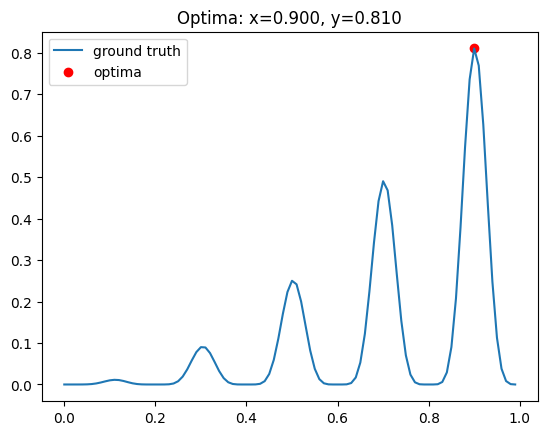

In [5]:
X = arange(0, 1, 0.01).reshape(-1,1)
y = array([objective(x, 0) for x in X]) # sampling w/o noise
ix = argmax(y)

plt.title('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))
plt.plot(X, y, label='ground truth')
plt.scatter(X[ix],y[ix], label='optima',color='red')
plt.legend()

Optima: x=0.900, y=0.810


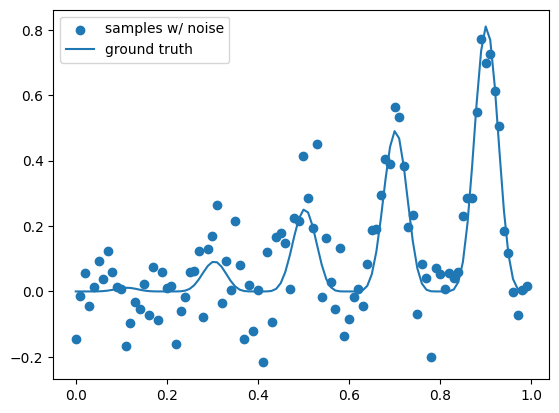

In [6]:
ynoise = array([objective(x) for x in X])
ix = argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))
plt.scatter(X, ynoise, label='samples w/ noise')
plt.plot(X,y, label='ground truth')
plt.legend()

## Surrogate Function

The surrogate function approximates the mapping of the inputs to an output score for the objective funciton, i.e. it gives the conditional probability that the function is $f$ given observed data $D$, $P(f|D)$.

The standard treatment uses a regression predictive model, with the data representing input and the score representing the output to the model. Often this is best modeled with a Gaussian process, which allows a smooth transition to updated function guesses. 

In [7]:
X.shape, y.shape

((100, 1), (100, 1))

In [8]:
# Gaussian process using sklearn
model = GaussianProcessRegressor()
model.fit(X, y)

GaussianProcessRegressor()

In [9]:
# yhat is a tuple (mean of f distribution, std of f distribution)
yhat = model.predict(X, return_std=True)

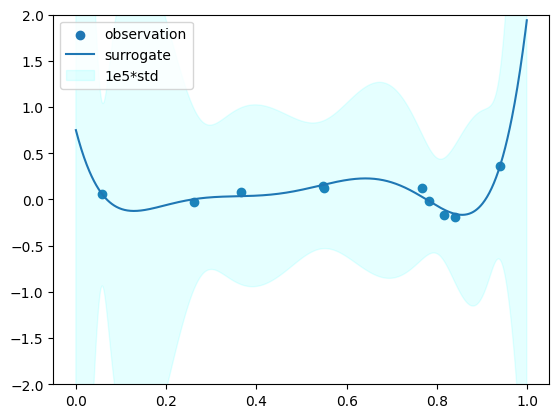

In [24]:
def surrogate(model, X):
    """
    approximation to the objective function
    """
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    # something is wrong... the std is almost zero everywhere
    
    fig, ax = plt.subplots()
    
    ax.scatter(X, y, label='observation')
    
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, ystd = surrogate(model, Xsamples)
    ax.plot(Xsamples, ysamples,label='surrogate')

    ax.fill_between(x=Xsamples.flatten(), 
                    y1=ysamples+1e5*ystd, 
                    y2=ysamples-1e5*ystd,
                    color=(0,1,1,0.1),
                    label='1e5*std')
    return ax

# sample the domain sparsely with noise
X = random.random(10)
y = asarray([objective(x) for x in X])

# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)

model = GaussianProcessRegressor()
model.fit(X, y)

# plot the surrogate function
ax = plot(X, y, model)
ax.set_ylim((-2,2))
# show the plot
plt.legend()
plt.show()

## Acquisition Function
The acquisition function is responsible for scoring or estimating the likelihood that a given candidate sample (input) is worth evaluating with the real objective function.

In [101]:
def acquisition(X, Xsamples, model):
    """
    probability of improvement acquisition function
    """
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
#     mu = mu[:, 0]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

def opt_acquisition(X, y, model):
    """
    model: GaussianProcessRegressor
    """
    
    # random search, generate random samples
    Xsamples = random.random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]

## Bayesian optimization algorithm

In [2]:
# sample the domain sparsely with noise
X = random.random(5)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

NameError: name 'random' is not defined

## Complete Bayesian optimization example